In [76]:
from rdkit import Chem
from rdkit.Chem import AllChem
from itertools import permutations
import numpy as np
import pandas as pd
from typing import List, Tuple
from rxntools import utils

In [77]:
JN_rules_df = pd.read_csv("../data/raw/JN1224MIN_rules.tsv", delimiter="\t")
cofactors_df = pd.read_csv("../data/raw/all_cofactors.csv")
KEGG_processed_df = pd.read_parquet("../data/processed/enzymemap_KEGG_JN_mapped_non_unique.parquet")


CC(C)(CO)[C@@H](O)C(=O)O.NCCC(=O)O.Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)[C@@H](O)[C@H]1O>>CC(C)(CO)[C@@H](O)C(=O)NCCC(=O)O.Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)O)[C@@H](O)[C@H]1O.O=P(O)(O)OP(=O)(O)O



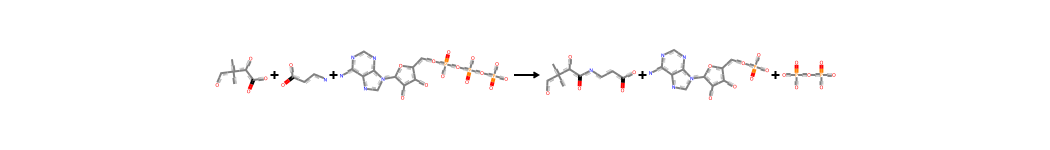

In [103]:
rule_ID = 'rule0067'
rxn_idx = 2
example_rxn = KEGG_processed_df[KEGG_processed_df["top_mapped_operator"]==rule_ID]["unmapped"].to_list()[rxn_idx]
print('')
print(example_rxn)
print('')
display(AllChem.ReactionFromSmarts(example_rxn))

rule_df = JN_rules_df
rule_SMARTS: str = rule_df[rule_df["Name"]==rule_ID]["SMARTS"].values[0] # of the form 'Any.NAD_CoF>>Any;NADH_CoF'
reactant_codes: str = rule_df[rule_df["Name"]==rule_ID]["Reactants"].values[0] # e.g., 'Any;NAD_CoF'
product_codes: str = rule_df[rule_df["Name"]==rule_ID]["Products"].values[0] # e.g., 'Any;NADH_CoF'

In [ ]:
reactants_SMILES_list: List[str] = example_rxn.split(">>")[0].split(".")
reactants_mols: List[Chem.Mol] = [Chem.MolFromSmiles(smiles) for smiles in reactants_SMILES_list]
useChirality = True
if None in reactants_mols:
    raise ValueError("One or more reactant SMILES could not be converted to RDKit Mol objects.")

all_reactant_combinations: List[Tuple[Chem.Mol, ...]] = list(permutations(reactants_mols, len(reactants_mols)))


lhs_template, rhs_template = rule_SMARTS.split('>>')
lhs_templates_list: List[str] = lhs_template.split('.') # list like [Any_SMARTS, NAD_CoF_SMARTS]
rhs_templates_list: List[str] = rhs_template.split('.') # list like [Any_SMARTS, NADH_CoF_SMARTS]

reactant_codes_list: List[str] = reactant_codes.split(';') # list like ['Any', 'NAD_CoF']
product_codes_list: List[str] = product_codes.split(';') # list like ['Any', 'NADH_CoF']

# initialize a list to store the correct order in which reactants should be positioned based on their SMARTS
# elucidating the correct order is necessary because RDKit's RunReactants() relies on the order of reactants passed to it
correct_reactant_combinations: List[Tuple[Chem.Mol, ...]]= []

# for each combination of reactant positioinings, check if the reactants match their corresponding SMARTS templates
for combination in all_reactant_combinations:

    num_matches = 0

    for (reactant_mol, lhs_template_SMARTS) in zip(combination, lhs_templates_list):
        if reactant_mol.HasSubstructMatch(Chem.MolFromSmarts(lhs_template_SMARTS), useChirality=useChirality):
            num_matches += 1
    
    if num_matches == len(lhs_templates_list):
        correct_reactant_combinations.append(combination)

# use RDKit's AllChem.RunReactants() to run the reaction for each correct reactant combination
all_products: List[Tuple[Chem.Mol, ...]] = []

for correct_combination in correct_reactant_combinations:
    rxn = AllChem.ReactionFromSmarts(rule_SMARTS)
    products: Tuple[Tuple[Chem.Mol, ...], ...] = rxn.RunReactants(correct_combination)
    for product_set in products:
        all_products.append(product_set)

# initialize a list to store the correct order in which products should be positioned based on their SMARTS
correct_product_combinations: List[str] = []

# for each combination of product positionings, check if the products match their corresponding SMARTS templates
for combination in all_products:

    num_matches = 0

    for (product_mol, rhs_template_SMARTS, product_code) in zip(combination, rhs_templates_list, product_codes_list):

        # first, check to see if the product mol object fits its corresponding SMARTS template
        if product_mol.HasSubstructMatch(Chem.MolFromSmarts(rhs_template_SMARTS), useChirality=useChirality):

            # then, if the product is a cofactor (i.e., not 'Any'), check to see that the correct cofactor has been produced
            if product_code != 'Any':
                if utils.are_isomorphic(product_mol, 
                                        Chem.MolFromSmiles(cofactors_df[cofactors_df["#ID"]==product_code]["SMILES"].to_list()[0])):
                    num_matches += 1
                else:
                    continue

            # but if the product is not a cofactor (i.e., 'Any') and its structure fits the corresponding SMARTS template, no further checking is needed
            elif product_code == 'Any':
                num_matches += 1

            else:
                continue

    if num_matches == len(rhs_templates_list):
        correct_product_combinations.append(combination)

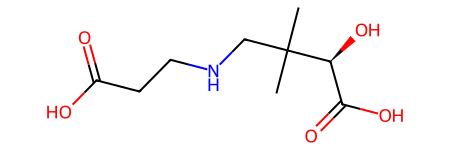

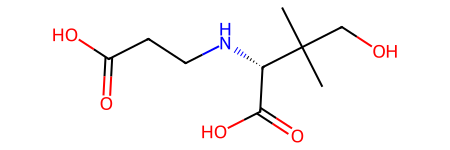

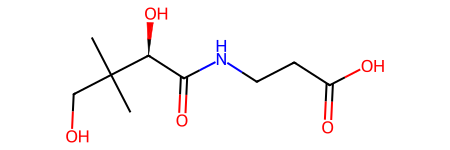

In [105]:
for product in correct_product_combinations:
    product_SMILES_list: List[str] = [Chem.MolToSmiles(mol) for mol in product]
    display(Chem.MolFromSmiles(product_SMILES_list[0]))